# Assignment B

TODO List:

1. Finish the network analysis + who is the most centeralised and why do we care? (Done)
2. Finish the basic exploration of the data (E.i. rating averages etc just to get it out (Done)
3. Create worldclouds for the plot of popular movies (e.i. highly rated) and pit it against the bad plots. Do we learn something? 
4. Create wordclouds for the cast of popular movies and pit them against one another. Does this tell us anything?
5. Pit the reception for popular movies against unpopular moviesm, what does this tell us?
6. Create a sentiment analysis of movies and plot the average sentiment of movies against one another (Done)


Feedback:
Sune -
Looks very nice, my comment is that there is some literature, that works on estimating success, have a look at literature on this topic for inspiration. Dont be disappointed if it fails, (in prediction). 

TAs
You can also look at the revenue. 

Should mention each actor is strongly connected to other actors, Ei. in groups of 4.


create degree plots and loglog and determine distribution, e.i. power law etc. Average shortest path. Modify community analysis to ignore communities of 4.

Generate wordclouds for plot, cast, reception??? perhaps compare these for different ratings, badly rated movies, middle rated and well liked. 

Show the point of eigenvector centrality, namely who the top actors are and what do we learn from this?... are their movies generally well recieved?

do a plot which bases colors in the force atlas plot on rating from green to red or something

## Motivation 
Our goal for this project is to explore what makes movies popular, in order to explore this we will need a set of movies to explore in terms of rating, plot and actors in order to determine if any elements are reoccuring for the success of a movie. It might be the actors, it might be common plot elements, or it may be a combination of all these. During the course of this explainer page we will go over the thoughts, ideas, analysis and learnings of exploring movie data.

- __What is your dataset?__

Our dataset consists of two parts firstly a list of 1000 popular movies. Secondly the respective wikipedia pages of those movies. The dataset is from kaggle, while the wiki pages are found on wikipedia. The base dataset can be found here:
https://www.kaggle.com/PromptCloudHQ/imdb-data

- __Why did you choose this/these particular dataset(s)?__

The dataset seemed to be a good fit for our porpose, firstly the set does contain bad & unpopular movies, which gives us a comparison basis which to explore. The wikia pages on the other hand can provide us a large amount of data, such as plot, cast and reception, and even controversies. 

- __What was your goal for the end user's experience?__

The user experience goal is to provide an interesting analysis which hightlights learnings generated throughout the course of this assignment and to display these in an understandable manner. We will directly enable data exploration in the plots, but leaves the users with access to our data so they may do so them selves should they wish so.

## Basic stats
- __Write about your choices in data cleaning and preprocessing__

Initially 1000 movies dataset contained the titles of all movies, this meant we initially started downloading wiki pages using these names, however we discovered some names are incomplete or incorrect. This meant if one attempted to access movies with books or having an implict meaning, one might be redirected to the wrong page. In order to combat this we implemented our download script in such a way it would first try the movie name_film_year, then name_film then name. This approach worked well for almost all the movies we needed, however left us with 50 missing movies, it was soon discovered these could not be found due to spelling differences or titles being in different languages. Therefore, we resolved this issue by manually updating the csv files to account for the correct names.

- __Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)__

Initially, our dataset consists of 1000 movies (303kb, 1000 rows and 12 variables), the data included in this set is: title, genre, short description, actors, year, length, ratings and revenue. In addition we have also generated text files corresponding to the wiki pages of each movie. The wikipedia data consists of 100 files totaling 4 mb. 

Initially, focusing on the actor interconnectivity we have 1985 nodes and 11994 links, in the actor graph the nodes have no attributes. In the movie graph however, there are multiple node attributes, such as rating, meta rating, number of votes and revenue.

## Tools, theory and analysis.
- __Talk about how you've worked with text, including regular expressions, unicode, etc.__
- __Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.__
- __How did you use the tools to understand your dataset?__

__(NOTE)__Each exploration section should be of the format:
- explain what you're interested in
- explain the tool
- apply the tool
- discuss the outcome

### Actor & movie networks analysis
Let us begin the analysis by looking at the network of actors connected per movie. This should give us an idea of what the communities look like and how the nodes interconnect. We would like to explore which actors are the most connected and in turn which movies.

In order to explore this we will use networkx, force atlas and community to explore these attributes.

Firstly, we will begin by preparing the data:

In [1]:
import io
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import numpy as np
import random as rm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

tweets = pd.read_csv('moviedata.csv')
linklist = []
nodes = []
movie_nodes = []
movie_links = []

#First round of processing, data is sorted to movie and actor nodes respectively
for index, row in tweets.iterrows():
    movie_nodes.append(row.Title)
    
    for j in list(row.Actors.replace(", ",",").split(",")):
        nodes.append(j)
        movie_links.append((row.Title,j))
        for n in list(row.Actors.replace(", ",",").split(",")):
            linklist.append((j,n))

#If a movie shares an actor with another movie, this connects the movies 
p_movie_links = []
for i in movie_links:
    for j in movie_links:
        if(i[1] == j[1]):
            p_movie_links.append((i[0],j[0]))

#Removes doublicates from actor links
nodes = list(set(nodes))
G = nx.DiGraph()
G.add_edges_from(linklist)
linklist = [i for i in linklist if i not in G.selfloop_edges()]
G.remove_edges_from(G.selfloop_edges())

#Print sizes:
print(len(nodes))
print(len(linklist))

print(len(movie_nodes))
print(len(p_movie_links))

1985
11994
1000
16083


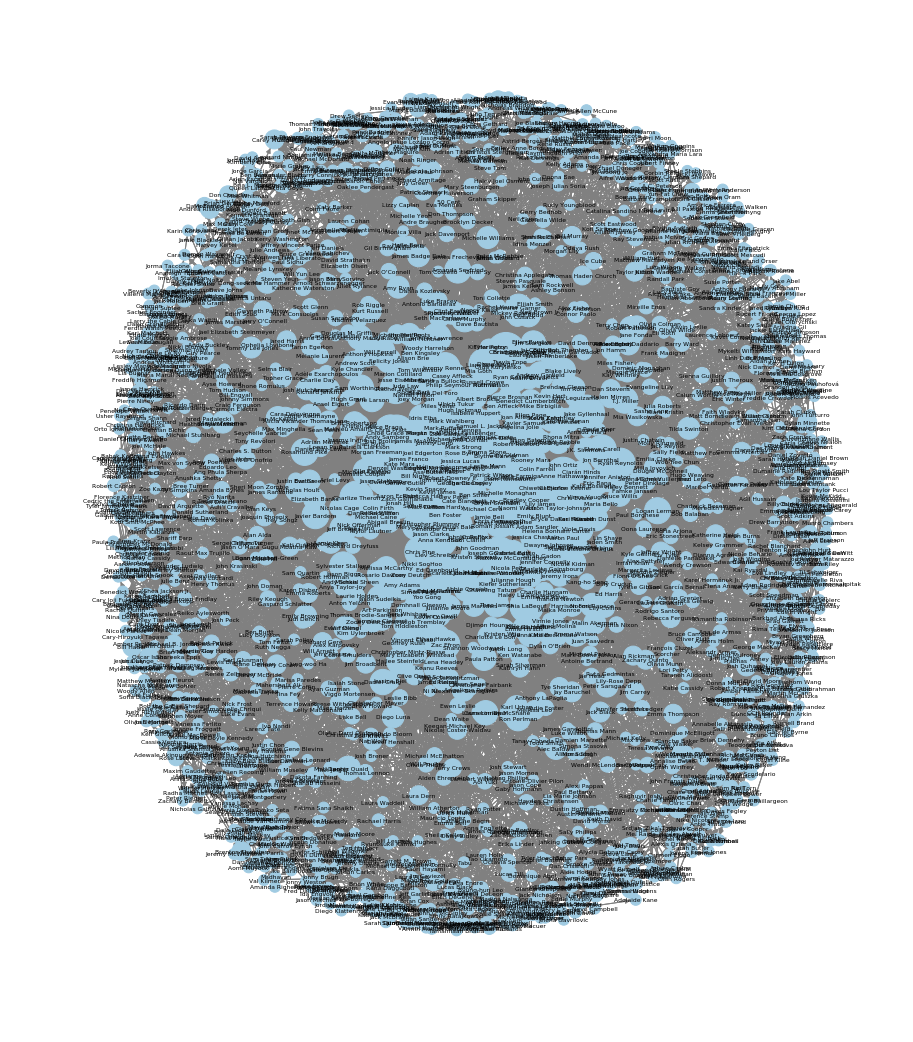

In [2]:
#Plot actor connectivity
d=G.degree()
plt.figure(1,figsize=(12,14))
pos=nx.spring_layout(G,k=20/(G.number_of_nodes()**0.5))
nx.draw(G, with_labels = True, node_size=[v[1] * 20 for v in d],font_size=6,pos=pos,edge_color='grey',node_color='#A0CBE2')
plt.show()

In the above plot we can see the actor interconnectivty is quite high. We can start seeing patters for which actors are more popular to cast in the movies. Alternatively we may visualize this using the force atlas algorithm:

In [3]:
from fa2 import ForceAtlas2

G_und = G.to_undirected()
dict(G_und.degree()).values()
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_und, pos=None, iterations=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.01it/s]


BarnesHut Approximation  took  1.10  seconds
Repulsion forces  took  4.46  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


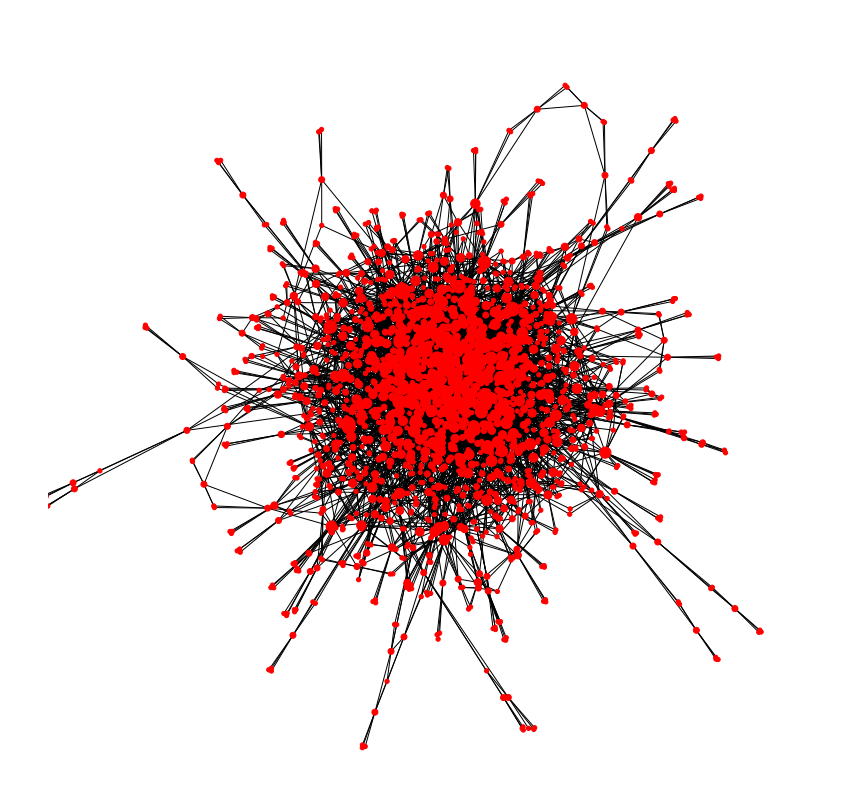

In [4]:
#Create figure:
plt.figure(figsize=(14,14))
nx.draw_networkx(G_und, pos=positions,with_labels=False, front_weight='bold',node_size=[6*i for i in dict(G_und.degree()).values()])
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

Force atlas representation of our actor network plot where node size is dependant on degrees for each node.

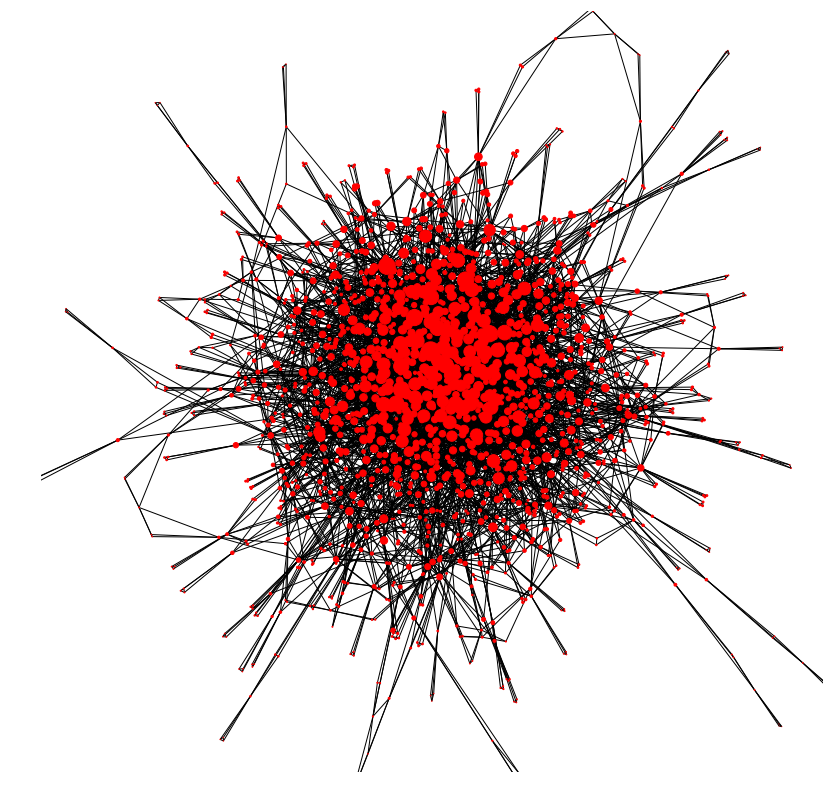

In [5]:
#Create eigenvector graph
plt.figure(figsize=(14,14))
bet_eig = nx.eigenvector_centrality(G)
nx.draw_networkx(G_und, pos=positions,with_labels=False, front_weight='bold',node_size=[bet_eig[i]*2000 for i in G_und.nodes()])
plt.xlim(-800,800)
plt.ylim(-800,800)
plt.axis('off')
plt.show()

Force atlas plot of the actor network where the node size is dependant on eigen vector centrality. Initially this plot provides us with an idea of each nodes realative influence, based on the scores of its connecions, thus nodes connected to other high degree nodes are highlighted more clearly

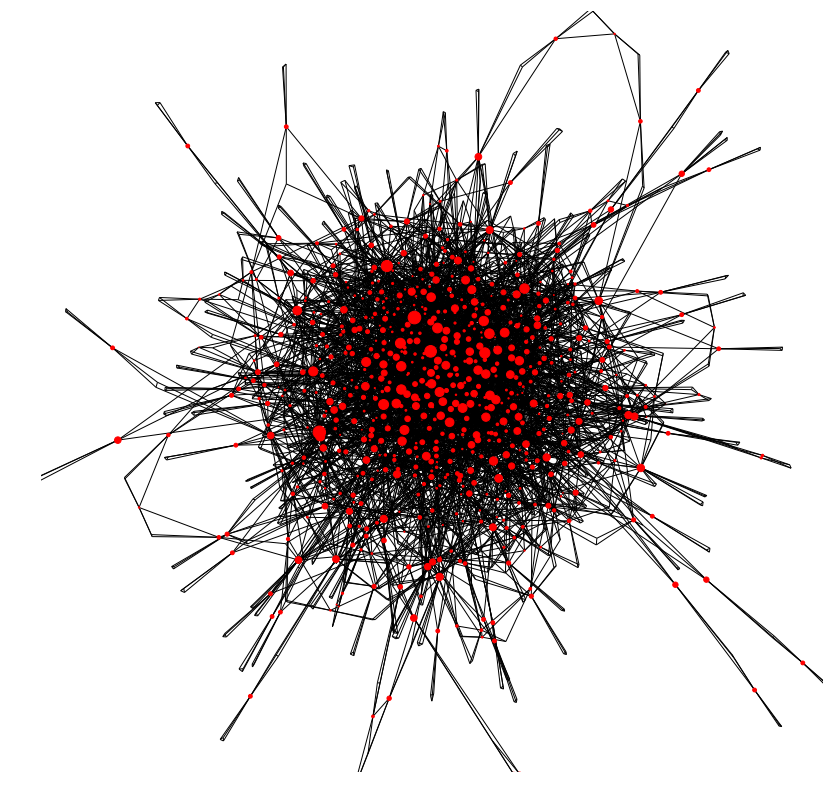

In [6]:
#Create Betweenness graph:
plt.figure(figsize=(14,14))
bet = nx.betweenness_centrality(G)
nx.draw_networkx(G_und, pos=positions,with_labels=False, front_weight='bold',node_size=[bet[i]*6000 for i in G_und.nodes()])
plt.xlim(-800,800)
plt.ylim(-800,800)
plt.axis('off')
plt.show()

Force atlas plot of the actor network where node size is dependant on the betweeness centrality. Effectively this highlighting nodes with the most shortest paths though the network. Effectively these represent the degree of which nodes stand between one another.

Lets look at the degree distribution of the network:

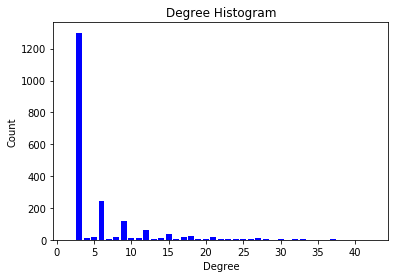

In [7]:
#Create histogram of degrees
import collections
degree_sequence = sorted([d for n, d in G_und.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

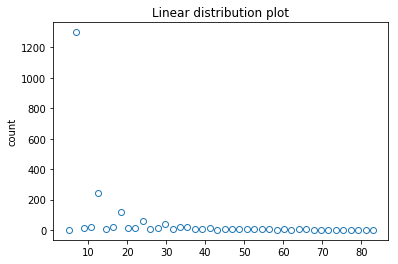

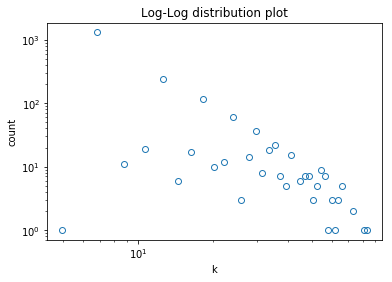

In [8]:
# Create linear distribution and loglog plot
maxd = max([int(j) for i,j in G_und.degree()])
mind = min([int(j) for i,j in G_und.degree()])
degreeslist = [int(j) for i,j in G_und.degree()]
hist, binList = np.histogram(degreeslist, maxd)
plt.plot((binList[1:]+binList[:-1]),hist, 'o', mfc='none')
plt.title("Linear distribution plot")
plt.ylabel('count')
plt.show()
#Generate log-log plot
plt.loglog((binList[1:]+binList[:-1]),hist, 'o', mfc='none')
plt.title("Log-Log distribution plot")
plt.xlabel('k')
plt.ylabel('count')
plt.show()

It should be noted that the distributions of degrees do not resemble any we have worked with in class, this can be accounted for by the fact that movies are rarely made with single actors, rather they usually have several main actors.

In [9]:
#Print most connected nodes by different measures
import operator
def sort_print_top3(dictionary):
    print(sorted([(i[0],dictionary[i[0]]) for i in G_und.nodes(data = True)],key = lambda x:x[1])[-10:],"\n")


und_degree = dict(G_und.degree())
print("Highest degrees")
sort_print_top3(und_degree)
print("Highest betweeness")
sort_print_top3(bet)
print("Highest eigenvector")
sort_print_top3(bet_eig)


Highest degrees
[('Chloë Grace Moretz', 32), ('Michael Fassbender', 33), ('Anne Hathaway', 33), ('Jake Gyllenhaal', 33), ('Tom Hardy', 33), ('Channing Tatum', 33), ('Christian Bale', 37), ('Brad Pitt', 37), ('Hugh Jackman', 41), ('Mark Wahlberg', 42)] 

Highest betweeness
[('Chloë Grace Moretz', 0.015051277694188257), ('Brad Pitt', 0.01532937250881317), ('Tom Hardy', 0.015752562762057963), ('Matthew McConaughey', 0.016513517147245343), ('Sharlto Copley', 0.016524995617116692), ('Charlize Theron', 0.017552710060818474), ('Hugh Jackman', 0.020767781714828865), ('Christian Bale', 0.022547365982506805), ('Channing Tatum', 0.025788127210341915), ('Mark Wahlberg', 0.026482896780064404)] 

Highest eigenvector
[('Tom Hardy', 0.113695448524933), ('Leonardo DiCaprio', 0.11636259764842105), ('Jake Gyllenhaal', 0.11651535177764859), ('Matt Damon', 0.1165236627557627), ('Anne Hathaway', 0.12713004686235388), ('Mark Wahlberg', 0.13088360019774828), ('Scarlett Johansson', 0.1325080510722002), ('Brad 

If we look at the most connected actors of each of our plots (degree, betweeness and eigen) we see that the most connected actors are the famous ones we might expect, ei the high end actors. This means that they are the most connected actors likely because they star in many films, rather than afew.

As expected serveral high end actors also show up in the most connected in betweeness centrality, however this also contains several relatively unknown actors, these can be accounted for by the nature of betweeness centrality and the fact that they bridge the graph between high end and low end actors.

The highest eigenvecor connected names, are as expected once more high end actors that star in movies with other highend actors, as indicated by our reults.

In [10]:
#Find the partition and print the modularity
import community
#first compute the best partition
partition = community.best_partition(G_und)
print(community.modularity(partition,G_und))

0.6248575593058865


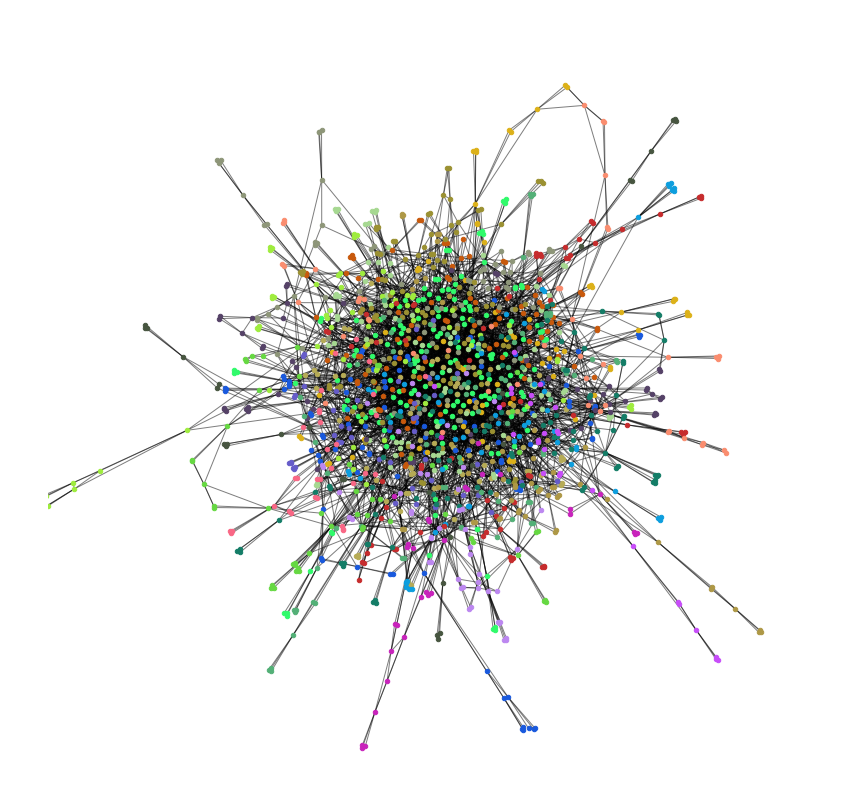

In [11]:
#Generate colors:
import random

COLORS = [(139, 0, 0), 
          (0, 100, 0),
          (0, 0, 139)]

def random_color():
    return random.choice(COLORS)

#begin figure
plt.figure(figsize=(14,14))
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
#Create communities graph:
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G_und, positions, list_nodes, node_size = 20,
                                node_color = np.random.rand(1,4))


nx.draw_networkx_edges(G_und,positions, alpha=0.5)
plt.show()

In [12]:
import prettytable # Requires pip install prettytable in the conda console 

#prints the community matrix
c_matrix = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    c_matrix.append([com,len(list_nodes)])

x = prettytable.PrettyTable(["Community:","Count"])

for n in c_matrix:    
    x.add_row([n[0], n[1]])

print(x)

+------------+-------+
| Community: | Count |
+------------+-------+
|     0      |  159  |
|     1      |   71  |
|     2      |   93  |
|     3      |   69  |
|     4      |   90  |
|     5      |   94  |
|     6      |   83  |
|     7      |  106  |
|     8      |   71  |
|     9      |   46  |
|     10     |   59  |
|     11     |   69  |
|     12     |   57  |
|     13     |   76  |
|     14     |   62  |
|     15     |   4   |
|     16     |   54  |
|     17     |   4   |
|     18     |   4   |
|     19     |   4   |
|     20     |  100  |
|     21     |   32  |
|     22     |   4   |
|     23     |   4   |
|     24     |   30  |
|     25     |   48  |
|     26     |   47  |
|     27     |   32  |
|     28     |   27  |
|     29     |   7   |
|     30     |   4   |
|     31     |   4   |
|     32     |   4   |
|     33     |   13  |
|     34     |   4   |
|     35     |   4   |
|     36     |   4   |
|     37     |   4   |
|     38     |   4   |
|     39     |   4   |
|     40   

When plotting the network for communities, several communities of highly interconnected actors appear, in which many participate in multiple movies togeather, so this interconnectivity makes sense in terms of hollywood movies.

#### Movie plots
Now that we have had a look at actors, its time to look at how the movies themselves are connected by actors, in this case movies that share actors have been linked together with the movies serving as the nodes.

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 13.01it/s]


BarnesHut Approximation  took  1.60  seconds
Repulsion forces  took  13.32  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


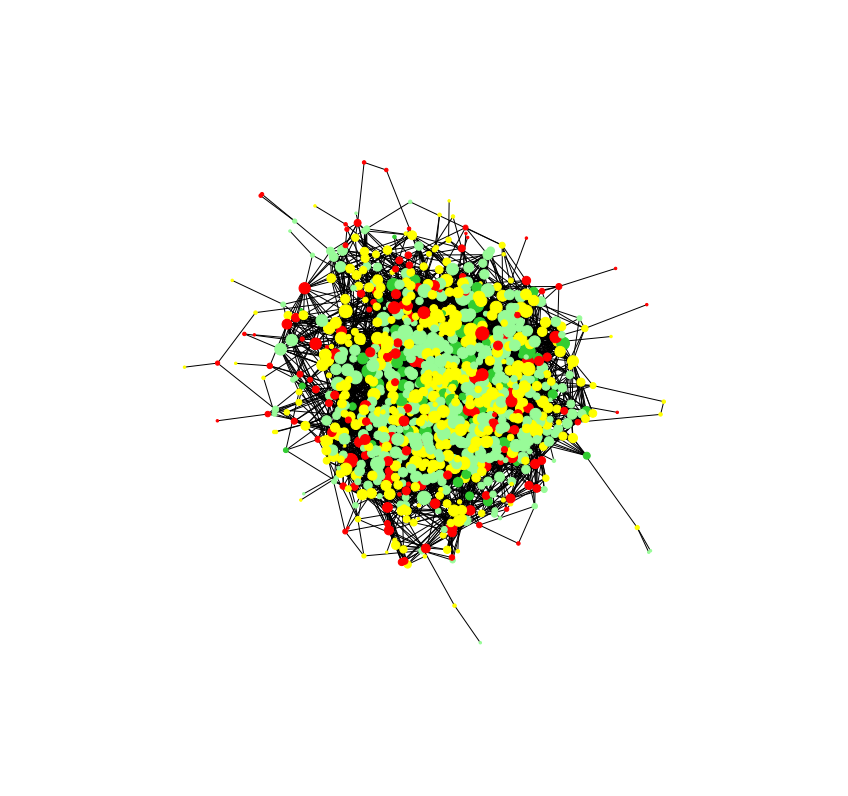

In [13]:
G_m = nx.DiGraph()


#Set node attributes
for i in movie_nodes:
    n = tweets.loc[tweets['Title'] == i]
    G_m.add_node(i, attr_dict = {'Rating' : n.Rating.astype(float),'Income' : n.Revenue.astype(float),'Score': n.Metascore, 'Votes':n.Votes})

#Remove doublicates
G_m.add_edges_from(p_movie_links)
G_m.remove_edges_from(G_m.selfloop_edges())
G_und_m = G_m.to_undirected()

#Generate colors:
cols = []
for i in G_und_m.nodes():
    try:
        if int(G_m.node[i]['attr_dict']['Rating']) >= 8:
            cols.append('#32CD32');
        elif int(G_m.node[i]['attr_dict']['Rating']) >= 7:
            cols.append('#98FB98')
        elif int(G_m.node[i]['attr_dict']['Rating']) >= 6: 
            cols.append('#ffff00')
        else: 
            cols.append('#ff0000')
    except:
        cols.append('#ff0000')


positions_m = forceatlas2.forceatlas2_networkx_layout(G_und_m, pos=None, iterations=200)
    
#Create movie figure:
plt.figure(figsize=(14,14))
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=[6*i for i in dict(G_und_m.degree()).values()],node_color=cols)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

Force atlas plot of movies, with colors based on movie ratings with node sizes being based on degrees.

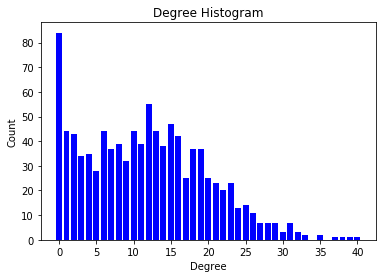

In [14]:
#print degree distribution for movie plot
degree_sequence = sorted([d for n, d in G_und_m.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

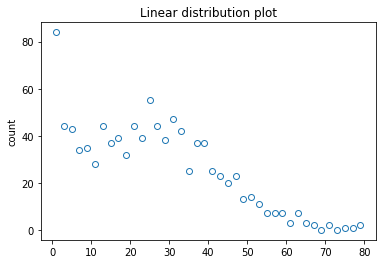

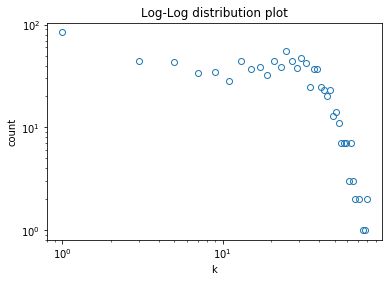

In [15]:
#Create linear distribution plot and loglog
maxd = max([int(j) for i,j in G_und_m.degree()])
mind = min([int(j) for i,j in G_und_m.degree()])
degreeslist = [int(j) for i,j in G_und_m.degree()]
hist, binList = np.histogram(degreeslist, maxd)
plt.plot((binList[1:]+binList[:-1]),hist, 'o', mfc='none')
plt.title("Linear distribution plot")
plt.ylabel('count')
plt.show()
#Generate log-log plot
plt.loglog((binList[1:]+binList[:-1]),hist, 'o', mfc='none')
plt.title("Log-Log distribution plot")
plt.xlabel('k')
plt.ylabel('count')
plt.show()

(array([  1.,   3.,   8.,  20.,  55., 154., 283., 281., 172.,  23.]),
 array([1.9 , 2.61, 3.32, 4.03, 4.74, 5.45, 6.16, 6.87, 7.58, 8.29, 9.  ]),
 <a list of 10 Patch objects>)

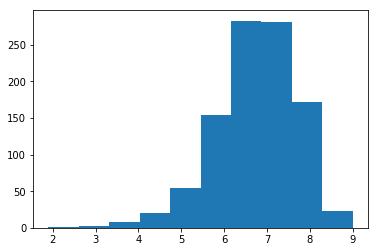

In [16]:
#Ratings histogram
plt.hist(tweets.Rating)

We can now change the plot and explore it from different aspects, lets start with chaning the size of nodes to be based on the income of the movies.

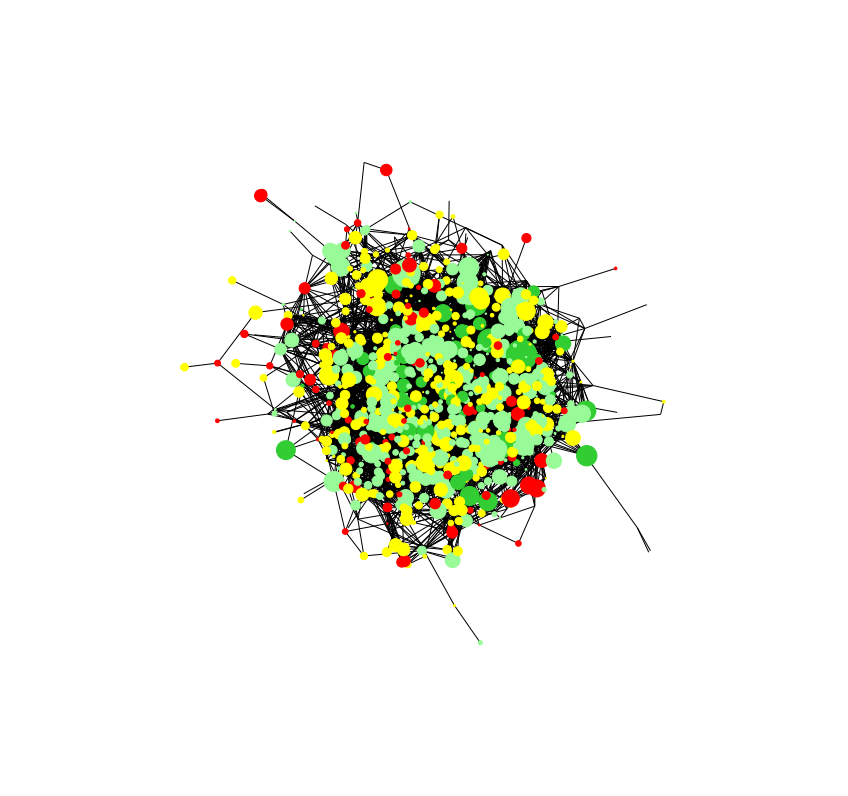

In [17]:
#Create where income determines node size, and colors are rating:
node_size = []
for i in G_und_m.nodes():
    try:
        node_size.append(int(G_m.node[i]['attr_dict']['Income']))
    except:
        node_size.append(0)

plt.figure(figsize=(14,14))
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=node_size,node_color=cols)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

(array([741., 151.,  56.,  33.,  11.,   3.,   2.,   0.,   1.,   1.]),
 array([  0. ,  93.6, 187.2, 280.8, 374.4, 468. , 561.6, 655.2, 748.8,
        842.4, 936. ]),
 <a list of 10 Patch objects>)

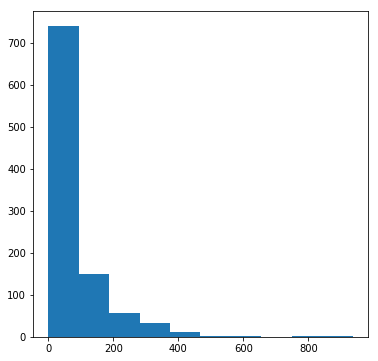

In [18]:
#Plot the movie earnings
plt.figure(figsize=(6,6))
plt.hist(node_size)

From the above network plot and histogram we can see that many movies have good earnings, but that these do not appear directly related to the coloring (e.i. rating of the movies).

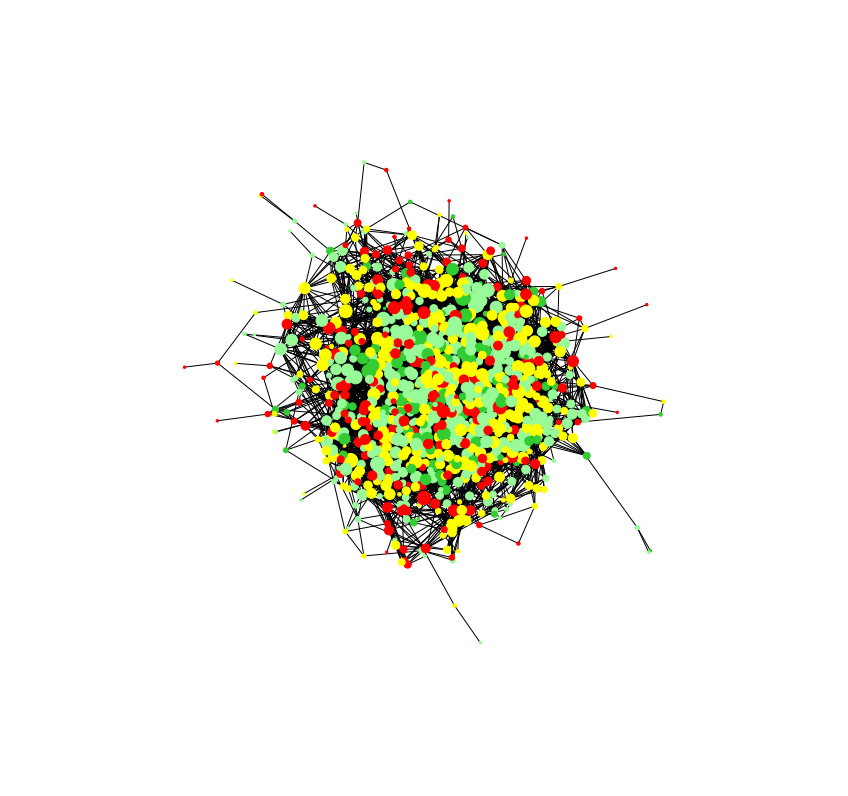

In [19]:
#Generate colors based on meta score:
cols = []
Scores = []
for i in G_und_m.nodes():
    try:
        Scores.append(int(G_m.node[i]['attr_dict']['Score']))
        if int(G_m.node[i]['attr_dict']['Score'] /10) >= 8:
            cols.append('#32CD32');
        elif int(G_m.node[i]['attr_dict']['Score']/10) >= 6:
            cols.append('#98FB98')
        elif int(G_m.node[i]['attr_dict']['Score']/10) >= 4: 
            cols.append('#ffff00')
        else: 
            cols.append('#ff0000')
    except:
        Scores.append(0)
        cols.append('#ff0000')

#Create figure:
plt.figure(figsize=(14,14))
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=[6*i for i in dict(G_und_m.degree()).values()],node_color=cols)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

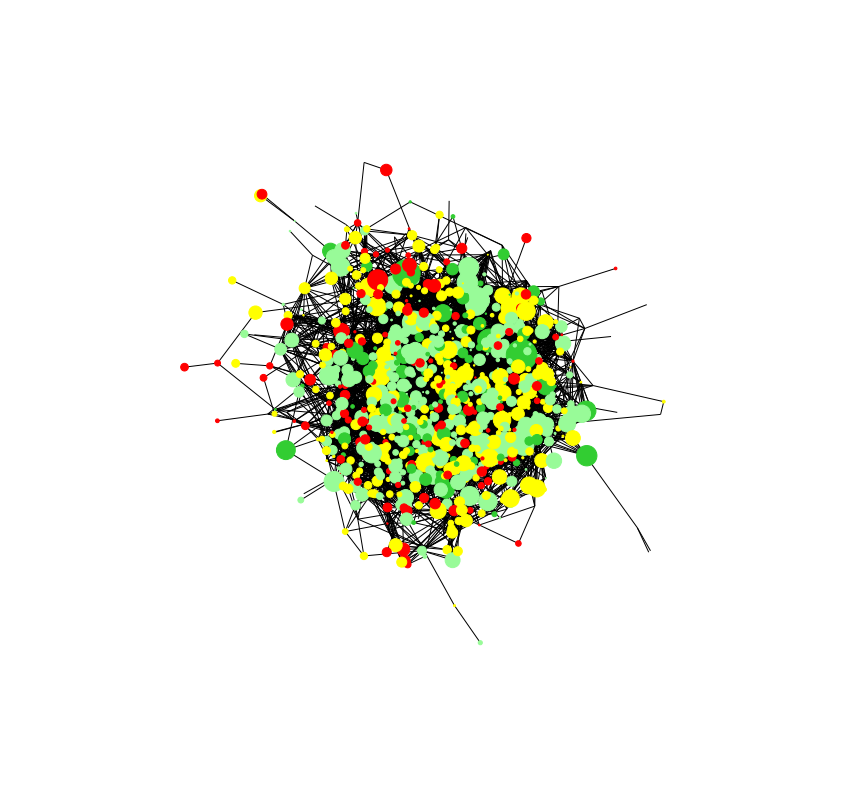

In [20]:
#Generate colors:
cols = []
Scores = []
for i in G_und_m.nodes():
    try:
        Scores.append(int(G_m.node[i]['attr_dict']['Score']))
        if int(G_m.node[i]['attr_dict']['Score'] /10) >= 8:
            cols.append('#32CD32');
        elif int(G_m.node[i]['attr_dict']['Score']/10) >= 6:
            cols.append('#98FB98')
        elif int(G_m.node[i]['attr_dict']['Score']/10) >= 4: 
            cols.append('#ffff00')
        else: 
            cols.append('#ff0000')
    except:
        Scores.append(0)
        cols.append('#ff0000')

#Create figure where node size is movie earnings:
plt.figure(figsize=(14,14))
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=node_size,node_color=cols)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.axis('off')
plt.show()

Initially chaning the node color based on meta score rather than imdb rating shows us nothing new. However plotting against earning as the node size we see that high rated meta score movies, clearly earn more than its low rated counter parts.

(array([ 65.,   8.,  29., 103., 145., 182., 196., 152.,  95.,  24.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

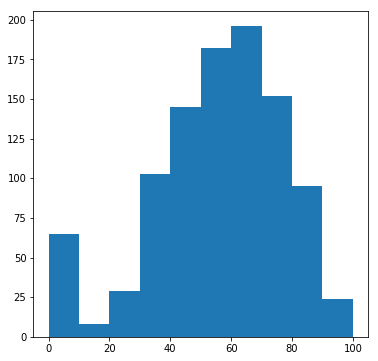

In [21]:
#plot average movie score
plt.figure(figsize=(6,6))
plt.hist(Scores)

As the histogram shows the user meta reviews are also slightly more diverse than its imdb counter part. We can now visualize the centrality using eigenvectors and betweeeness.

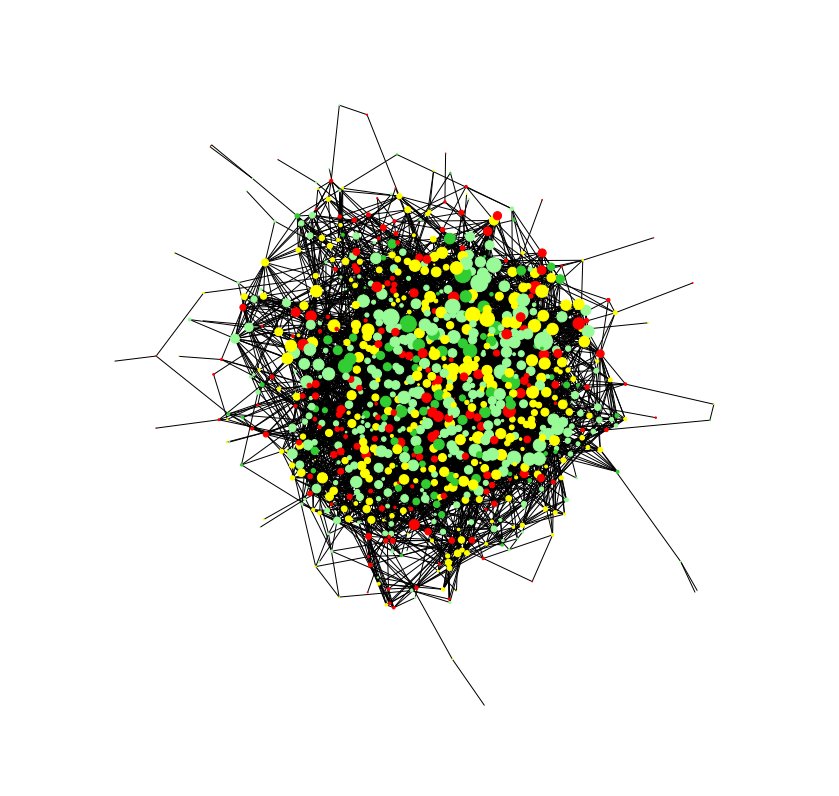

In [22]:
#Create Eigenvector graph
plt.figure(figsize=(14,14))
bet_eig = nx.eigenvector_centrality(G_und_m)
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=[bet_eig[i]*2000 for i in G_und_m.nodes()],node_color=cols)
plt.xlim(-800,800)
plt.ylim(-800,800)
plt.axis('off')
plt.show()

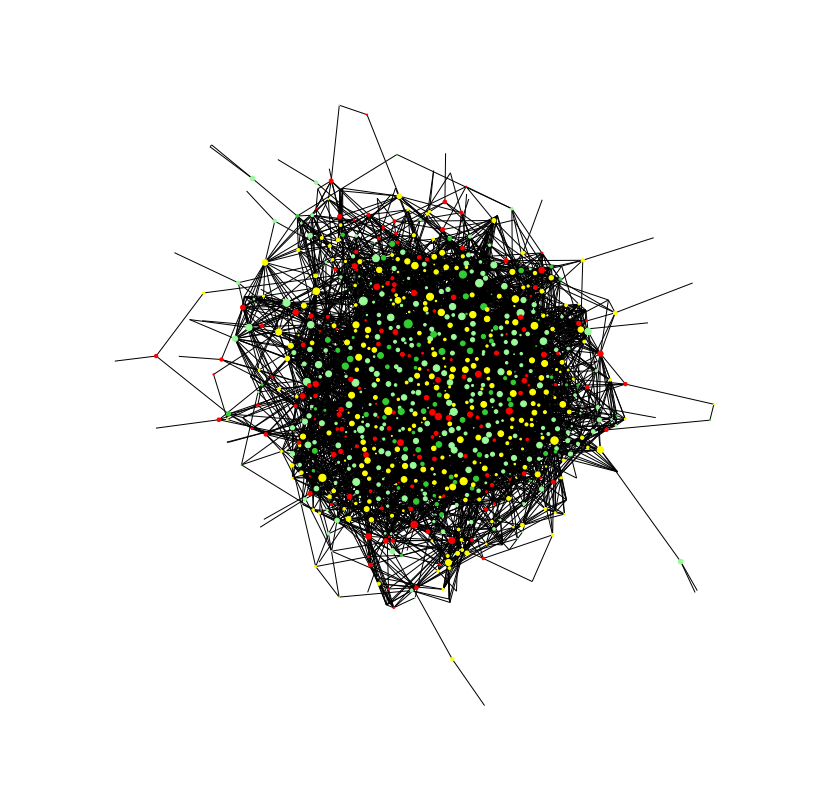

In [23]:
#Create betweenness graph.
plt.figure(figsize=(14,14))
bet = nx.betweenness_centrality(G_und_m)
nx.draw_networkx(G_und_m, pos=positions_m,with_labels=False, front_weight='bold',node_size=[bet[i]*6000 for i in G_und_m.nodes()],node_color=cols)
plt.xlim(-800,800)
plt.ylim(-800,800)
plt.axis('off')
plt.show()

In [24]:
#Plot most connected movies by different measures
def sort_print_top3(dictionary):
    print(sorted([(i[0],dictionary[i[0]]) for i in G_und_m.nodes(data = True)],key = lambda x:x[1])[-10:],"\n")

print("most connected movies")
und_degree = dict(G_und_m.degree())
print("Highest degrees")
sort_print_top3(und_degree)
print("Highest betweeness")
sort_print_top3(bet)
print("Highest eigenvector")
sort_print_top3(bet_eig)

most connected movies
Highest degrees
[('The Avengers', 32), ('The Departed', 32), ('Neighbors 2: Sorority Rising', 33), ('50/50', 33), ('Les Misérables', 35), ('The Fighter', 35), ('American Hustle', 37), ('The Big Short', 38), ('The Dark Knight Rises', 39), ('The Prestige', 40)] 

Highest betweeness
[('American Gangster', 0.008398659159022312), ('Neighbors 2: Sorority Rising', 0.008481245852285988), ('The Book of Life', 0.008493781583621886), ('American Hustle', 0.00863873426448633), ('Hancock', 0.008715510075035791), ('The Magnificent Seven', 0.008983352759737774), ('Snow White and the Huntsman', 0.009291364437932966), ('The Dark Knight Rises', 0.009411000685469226), ('Fury', 0.010209825126819077), ('The Big Short', 0.010811293388329741)] 

Highest eigenvector
[('Public Enemies', 0.1043018318606311), ('Knight of Cups', 0.10753135926865841), ('Exodus: Gods and Kings', 0.1089982825379664), ('Out of the Furnace', 0.11082532866032672), ('Les Misérables', 0.11159330425382281), ('The Big 

As somewhat expected, the high end movies are the most connected with many high end actors present.

0.5008190815882166


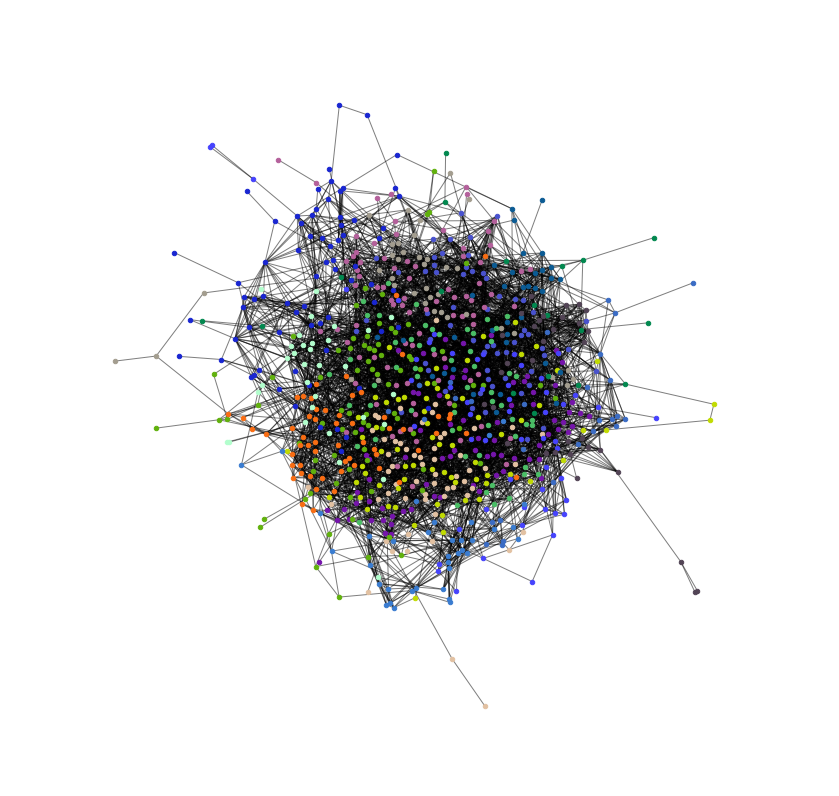

In [25]:
#first compute the best partition
partition = community.best_partition(G_und_m)

print(community.modularity(partition,G_und_m))
#drawing
plt.figure(figsize=(14,14))
plt.xlim(-800,800)
plt.ylim(-800,800)
plt.axis('off')
#Create figure:
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G_und_m, positions_m, list_nodes, node_size = 20,
                                node_color = np.random.rand(1,4))


nx.draw_networkx_edges(G_und_m,positions_m, alpha=0.5)
plt.show()

In [26]:
#Print matrix for communities
c_matrix = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    c_matrix.append([com,len(list_nodes)])

x = prettytable.PrettyTable(["Community:","Count"])

for n in c_matrix:    
    x.add_row([n[0], n[1]])

print(x)

+------------+-------+
| Community: | Count |
+------------+-------+
|     0      |   60  |
|     1      |   78  |
|     2      |   58  |
|     3      |   68  |
|     4      |   81  |
|     5      |   54  |
|     6      |   85  |
|     7      |   72  |
|     8      |   35  |
|     9      |   39  |
|     10     |   57  |
|     11     |   1   |
|     12     |   1   |
|     13     |   1   |
|     14     |   1   |
|     15     |   58  |
|     16     |   36  |
|     17     |   28  |
|     18     |   1   |
|     19     |   1   |
|     20     |   19  |
|     21     |   33  |
|     22     |   32  |
|     23     |   2   |
|     24     |   1   |
|     25     |   1   |
|     26     |   1   |
|     27     |   4   |
|     28     |   1   |
|     29     |   1   |
|     30     |   1   |
|     31     |   1   |
|     32     |   1   |
|     33     |   1   |
|     34     |   1   |
|     35     |   1   |
|     36     |   1   |
|     37     |   2   |
|     38     |   1   |
|     39     |   1   |
|     40   

Given the actor and movie analysis we can clearly see that quite afew popular movies are well connected such as the prestige and the dark night rises which are both highly acclaimed movies. Popular actors such as Hugh Jackman, Christian Bale and Brad Pitt are also among the most interconnected, indicating that there is likely a connecting between highly connected actors and popular movies. 

## Discussion. Think critically about your creation
- __What went well?,__
- __What is still missing? What could be improved?, Why?__

### Wikipedia Scraping, Wordcloud and Sentiment analysis

In this section, we are collecting data from Wikipedia based on the movie dataset. We are looking at text describing the plot and the cast of the movies. We are dividing the movies into two categories, popular and unpopular movies, based on their ratings. We will construct Wordclouds from the two categories as a result of the plot and cast data from Wikipedia. We will also do a sentiment analysis on the data.

**Collect all plot sections from the respective Wikipedia pages of movies with rating above 7**

In [27]:
import wikipedia
movies = pd.read_csv('moviedata.csv')
#Look at movies with rating above 7 only
popularmovie_plots=[]
for index, row in movies.iterrows():
    
    film=movies.Title[index]+' ('+str(movies.Year[index])+' film)'
    if movies.Rating[index]>7:
        
        try:
            # get the section of a page. In this case the Plot description 
            section = wikipedia.WikipediaPage(film).section('Plot')

            # that will return fairly clean text, but the next line of code
            # will help clean that up.
            section = section.replace('\n','').replace("\'","")
            popularmovie_plots.append(section)

        except:
            try: 
                film=movies.Title[index]+' (film)'
                section = wikipedia.WikipediaPage(film).section('Plot')

                section = section.replace('\n','').replace("\'","")
                popularmovie_plots.append(section)

                #Skip movie if it doesnt findt it 

            except:   
                try: 
                    film=movies.Title[index]
                    section = wikipedia.WikipediaPage(film).section('Plot')

                    section = section.replace('\n','').replace("\'","")
                    popularmovie_plots.append(section)

                    #Skip movie if it doesnt findt it 
                except:
                    try: 
                        film=movies.Title[index]+' ('+str(movies.Year[index])+' American film)'
                        section = wikipedia.WikipediaPage(film).section('Plot')

                        section = section.replace('\n','').replace("\'","")
                        popularmovie_plots.append(section)

                    #Skip movie if it doesnt findt it 
                    except:
                        pass


C:\Users\danma\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\danma\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


**Collect all plot sections from the respective Wikipedia pages of movies with rating less than 6**

In [28]:
#Look at movies with ratings less than 6 only
unpopularmovie_plots=[]
for index, row in movies.iterrows():
    #print(index)
    film=movies.Title[index]+' ('+str(movies.Year[index])+' film)'
    if movies.Rating[index]<6:
        
        #print(film)

        try:
            # get the section of a page. In this case the Plot description 
            section = wikipedia.WikipediaPage(film).section('Plot')

            # that will return fairly clean text, but the next line of code
            # will help clean that up.
            section = section.replace('\n','').replace("\'","")
            unpopularmovie_plots.append(section)

        except:
            try: 
                film=movies.Title[index]+' (film)'
                section = wikipedia.WikipediaPage(film).section('Plot')

                section = section.replace('\n','').replace("\'","")
                unpopularmovie_plots.append(section)

                #Skip movie if it doesnt findt it 

            except:   
                try: 
                    film=movies.Title[index]
                    section = wikipedia.WikipediaPage(film).section('Plot')

                    section = section.replace('\n','').replace("\'","")
                    unpopularmovie_plots.append(section)

                except:
                    try: 
                        film=movies.Title[index]+' ('+str(movies.Year[index])+' American film)'
                        section = wikipedia.WikipediaPage(film).section('Plot')

                        section = section.replace('\n','').replace("\'","")
                        unpopularmovie_plots.append(section)

                    except:
                        pass

C:\Users\danma\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\danma\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [29]:
#Convert the negative plot sections from a list of strings to one string
popularmovie_plots1="".join(popularmovie_plots)

#processing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#Tokenization & remove all "."s and \d's
print(len(popularmovie_plots1))
#Remove newlines
popularmovie_plots1= popularmovie_plots1.replace('\\n'," ").replace('.','')
print(len(popularmovie_plots1))

tokenizer = RegexpTokenizer(r'\w+')
popularmovie_plots1_tokens = tokenizer.tokenize(popularmovie_plots1)
print(len(popularmovie_plots1))

#Remove stop words & lower
stopset = set(stopwords.words('english'))
popularmovie_plots1_tokens = [w for w in popularmovie_plots1_tokens if not w in stopset]

print(len(popularmovie_plots1_tokens))
print(len(set(popularmovie_plots1_tokens)))

1478997
1465748
1465748
148562
24017


In [30]:
#calculate the tf and idf of every word:
import math
from collections import Counter

#get the unique words:
plot_unique_words = set(popularmovie_plots1_tokens)

plot_counts = Counter(popularmovie_plots1_tokens)
index = 0 
tf_idf_plot = []
for n in plot_unique_words.union(plot_unique_words):
    n_t = 0
    if n in plot_unique_words:
        n_t = n_t+1
        
    word_idf = math.log10(2/n_t)    

    tf_idf_plot.append((n, plot_counts[n]*word_idf))

**Wordcloud on plots from popular movies**

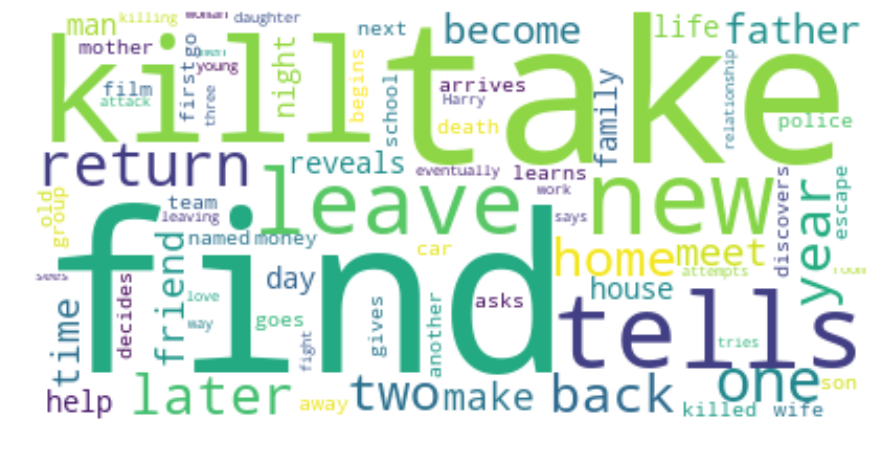

In [31]:
# word cloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

sortedlist = sorted(tf_idf_plot, key = lambda x: x[1], reverse =True)
text = ""
for i in range(100):
    text = text + int(sortedlist[i][1])*(sortedlist[i][0] + " ")
wc = WordCloud(background_color="white", max_words=300, collocations = False)
wc.generate(text)

# Show
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [32]:
#Convert the negative plot sections from a list of strings to one string
unpopularmovie_plots1="".join(unpopularmovie_plots)

#processing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#Tokenization & remove all "."s and \d's
print(len(unpopularmovie_plots1))
#Remove newlines
unpopularmovie_plots1= unpopularmovie_plots1.replace('\\n'," ").replace('.','')
print(len(unpopularmovie_plots1))

tokenizer = RegexpTokenizer(r'\w+')
unpopularmovie_plots1_tokens = tokenizer.tokenize(unpopularmovie_plots1)
print(len(unpopularmovie_plots1))

#Remove stop words & lower
stopset = set(stopwords.words('english'))
unpopularmovie_plots1_tokens = [w for w in unpopularmovie_plots1_tokens if not w in stopset]

print(len(unpopularmovie_plots1_tokens))
print(len(set(unpopularmovie_plots1_tokens)))

616042
610567
610567
61848
13526


In [33]:
#calculate the tf and idf of every word:
import math
from collections import Counter

#get the unique words:
unplot_unique_words = set(unpopularmovie_plots1_tokens)

plot_counts = Counter(unpopularmovie_plots1_tokens)
index = 0 
tf_idf_plot = []
for n in plot_unique_words.union(plot_unique_words):
    n_t = 0
    if n in plot_unique_words:
        n_t = n_t+1
        
    word_idf = math.log10(2/n_t)    

    tf_idf_plot.append((n, plot_counts[n]*word_idf))

**Wordcloud on plots from unpopular movies**

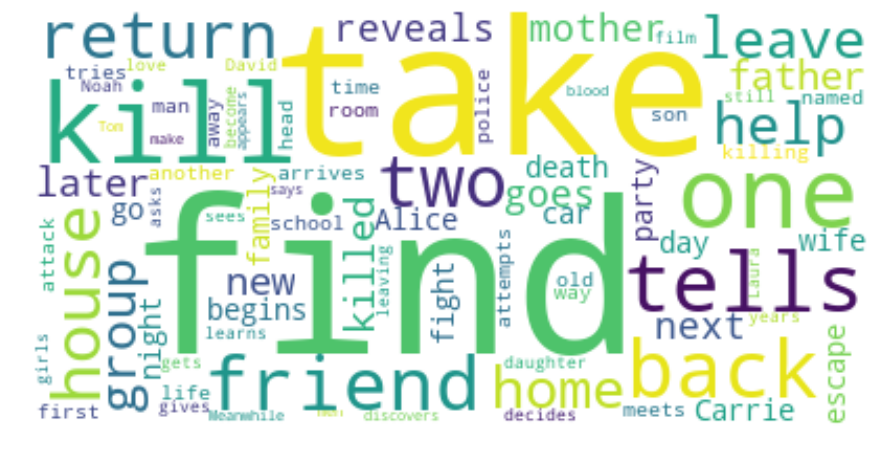

In [34]:
# word cloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

sortedlist = sorted(tf_idf_plot, key = lambda x: x[1], reverse =True)
text = ""
for i in range(100):
    text = text + int(sortedlist[i][1])*(sortedlist[i][0] + " ")
wc = WordCloud(background_color="white", max_words=300, collocations = False)
wc.generate(text)

# Show
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show() 

## Collect data from cast section

In [35]:
#Look at movies with rating above 7 only
popularmovie_casts=[]
for index, row in movies.iterrows():
    
    film=movies.Title[index]+' ('+str(movies.Year[index])+' film)'
    if movies.Rating[index]>7:
        
        

        try:
            # get the section of a page. In this case the Cast description 
            section = wikipedia.WikipediaPage(film).section('Cast')

            # that will return fairly clean text, but the next line of code
            # will help clean that up.
            section = section.replace('\n','').replace("\'","")
            popularmovie_casts.append(section)

        except:
            try: 
                film=movies.Title[index]+' (film)'
                section = wikipedia.WikipediaPage(film).section('Cast')

                section = section.replace('\n','').replace("\'","")
                popularmovie_casts.append(section)

                #Skip movie if it doesnt findt it 

            except:   
                try: 
                    film=movies.Title[index]
                    
                    section = wikipedia.WikipediaPage(film).section('Cast')

                    section = section.replace('\n','').replace("\'","")
                    popularmovie_casts.append(section)

                except:
                    try: 
                        film=movies.Title[index]+' ('+str(movies.Year[index])+' American film)'
                        section = wikipedia.WikipediaPage(film).section('Cast')

                        section = section.replace('\n','').replace("\'","")
                        popularmovie_cassts.append(section)

                    except:
                        pass


C:\Users\danma\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\danma\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [36]:
#Look at movies with ratings less than 6only
unpopularmovie_casts=[]
for index, row in movies.iterrows():
    #print(index)
    film=movies.Title[index]+' ('+str(movies.Year[index])+' film)'
    if movies.Rating[index]<6:
        
        #print(film)

        try:
            # get the section of a page. In this case the Cast description 
            section = wikipedia.WikipediaPage(film).section('Cast')

            section = section.replace('\n','').replace("\'","")
            unpopularmovie_casts.append(section)

        except:
            try: 
                film=movies.Title[index]+' (film)'
                section = wikipedia.WikipediaPage(film).section('Cast')

                section = section.replace('\n','').replace("\'","")
                unpopularmovie_casts.append(section)

                #Skip movie if it doesnt findt it 

            except:   
                try: 
                    film=movies.Title[index]
                    section = wikipedia.WikipediaPage(film).section('Cast')

                    section = section.replace('\n','').replace("\'","")
                    unpopularmovie_casts.append(section)

                except:
                    try: 
                        film=movies.Title[index]+' ('+str(movies.Year[index])+' American film)'
                        section = wikipedia.WikipediaPage(film).section('Cast')

                        section = section.replace('\n','').replace("\'","")
                        unpopularmovie_cassts.append(section)

                    except:
                        pass


C:\Users\danma\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\danma\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [37]:
#Convert the cast of popularmovies from a list of strings to one string
cast1="".join(popularmovie_casts)

446265
442165
73542
45999
15170


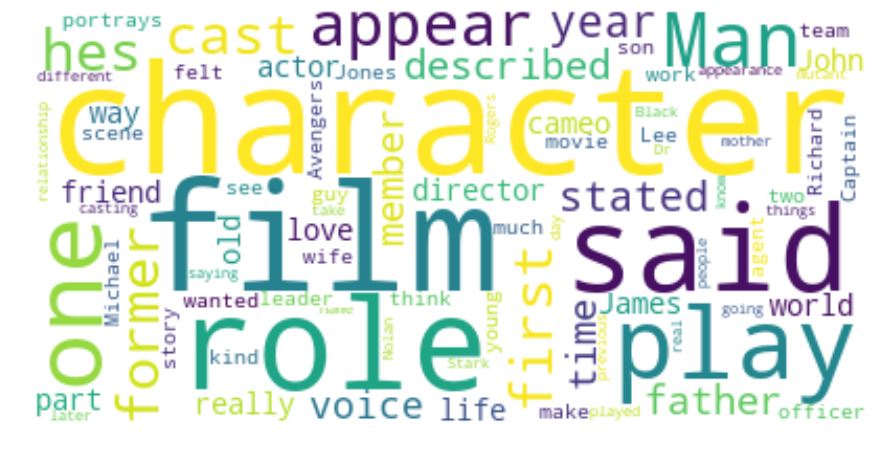

In [38]:
#processing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#Tokenization & remove all "."s and \d's
print(len(cast1))
#Remove newlines
cast1= cast1.replace('\\n'," ").replace('.','')
print(len(cast1))

tokenizer = RegexpTokenizer(r'\w+')
cast_tokens = tokenizer.tokenize(cast1)
print(len(cast_tokens))

#Remove stop words & lower
stopset = set(stopwords.words('english'))
cast_tokens = [w for w in cast_tokens if not w in stopset]

print(len(cast_tokens))
print(len(set(cast_tokens)))

#calculate the tf and idf of every word in republian tweets:
import math
from collections import Counter

#get the unique words:
cast_unique_words = set(cast_tokens)

cast_counts = Counter(cast_tokens)
index = 0 
tf_idf_cast = []
for n in cast_unique_words.union(cast_unique_words):
    n_t = 0
    if n in cast_unique_words:
        n_t = n_t+1
        
    word_idf = math.log10(2/n_t)    

    tf_idf_cast.append((n, cast_counts[n]*word_idf))

#word cloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

sortedlist = sorted(tf_idf_cast, key = lambda x: x[1], reverse =True)
text = ""
for i in range(100):
    text = text + int(sortedlist[i][1])*(sortedlist[i][0] + " ")
wc = WordCloud(background_color="white", max_words=300, collocations = False)
wc.generate(text)

# Show
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [39]:
#Convert the casts of unpopularmove from a list of strings to one string
cast1="".join(unpopularmovie_casts)

99197
98408
15923
10226
5841


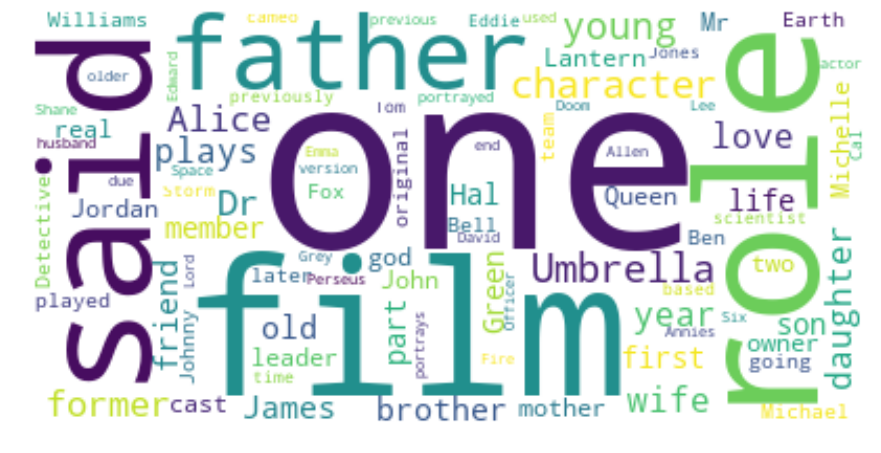

In [40]:
#processing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#Tokenization & remove all "."s and \d's
print(len(cast1))
#Remove newlines
cast1= cast1.replace('\\n'," ").replace('.','')
print(len(cast1))

tokenizer = RegexpTokenizer(r'\w+')
cast_tokens = tokenizer.tokenize(cast1)
print(len(cast_tokens))

#Remove stop words & lower
stopset = set(stopwords.words('english'))
cast_tokens = [w for w in cast_tokens if not w in stopset]

print(len(cast_tokens))
print(len(set(cast_tokens)))

#calculate the tf and idf of every word in republian tweets:
import math
from collections import Counter

#get the unique words:
cast_unique_words = set(cast_tokens)

cast_counts = Counter(cast_tokens)
index = 0 
tf_idf_cast = []
for n in cast_unique_words.union(cast_unique_words):
    n_t = 0
    if n in cast_unique_words:
        n_t = n_t+1
        
    word_idf = math.log10(2/n_t)    

    tf_idf_cast.append((n, cast_counts[n]*word_idf))

#word cloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

sortedlist = sorted(tf_idf_cast, key = lambda x: x[1], reverse =True)
text = ""
for i in range(100):
    text = text + int(sortedlist[i][1])*(sortedlist[i][0] + " ")
wc = WordCloud(background_color="white", max_words=300, collocations = False)
wc.generate(text)

# Show
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show() 

## Sentiment analysis

In [41]:
import nltk
#Set the path for the Data Set S1 txt file from Lab MT
path = 'sentimentWords.TXT'
header = ['word', 'hapiness_rank', 'happiness_average', 'hapiness_standard_deviation', 'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank']
happy_data = pd.read_csv(path, delimiter='\t',skiprows=3)
happinessDict = dictionary = dict(zip(happy_data.word, happy_data.happiness_average))

#function that calculates sentiment

def how_happy(tokens):# Given tokens return happines
    
    happiness_counter=[]
    for word in tokens:
        word = word.lower()
                
        happiness_word=happinessDict.get(word,0)
        if happiness_word != 0:
            happiness_counter.append(happiness_word)
    
    
    happiness_counter=np.mean(happiness_counter)
    return happiness_counter


In [42]:
sentiment_popularmovie_plot=[]

for n in popularmovie_plots:
    
    try:
        sentiment_popularmovie_plot.append(how_happy(nltk.word_tokenize(n)))
        
    except:
        pass

C:\Users\danma\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\danma\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
sentiment_unpopularmovie_plot=[]

for n in unpopularmovie_plots:
    
    try:
        sentiment_unpopularmovie_plot.append(how_happy(nltk.word_tokenize(n)))
        
    except:
        pass

In [44]:
#remove nans
sentiment_popularmovie_plot = [x for x in sentiment_popularmovie_plot if str(x) != 'nan']
#remove nans
sentiment_unpopularmovie_plot = [x for x in sentiment_unpopularmovie_plot if str(x) != 'nan']


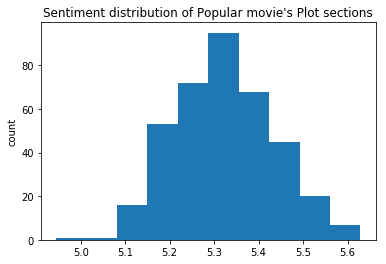

Mean sentiment of popularmovie plots:
5.323384591466538
Std sentiment of popularmovie plots:
0.1107360909938037


In [45]:
import matplotlib.pyplot as plt
plt.hist(sentiment_popularmovie_plot)
plt.title("Sentiment distribution of Popular movie's Plot sections")
plt.ylabel('count')
#plt.xlim(3,8)
plt.show()

mean_popularmovie_plot=np.mean(sentiment_popularmovie_plot)
print('Mean sentiment of popularmovie plots:')
print(mean_popularmovie_plot)
std_popularmovie_plot=np.std(sentiment_popularmovie_plot)
print('Std sentiment of popularmovie plots:')
print(std_popularmovie_plot)

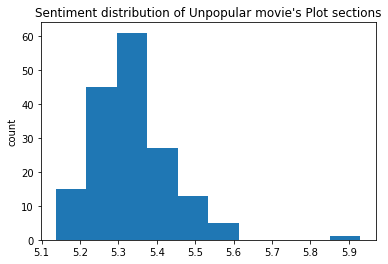

Mean sentiment of popularmovie plots:
5.335842047490892
Std sentiment of popularmovie plots:
0.1031744985061691


In [46]:
import matplotlib.pyplot as plt
plt.hist(sentiment_unpopularmovie_plot)
plt.title("Sentiment distribution of Unpopular movie's Plot sections")
plt.ylabel('count')
#plt.xlim(3,8)
plt.show()

mean_unpopularmovie_plot=np.mean(sentiment_unpopularmovie_plot)
print('Mean sentiment of popularmovie plots:')
print(mean_unpopularmovie_plot)
std_unpopularmovie_plot=np.std(sentiment_unpopularmovie_plot)
print('Std sentiment of popularmovie plots:')
print(std_unpopularmovie_plot)